In [3]:
import tensorflow as tf
print(tf.__version__)

2.6.2


In [4]:
pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /opt/conda/lib/python3.6/site-packages (2.6.2)
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install efficientnet

Note: you may need to restart the kernel to use updated packages.


In [6]:
from tensorflow.keras.applications import EfficientNetB0

## Restrat Kernel and run from below code

In [7]:
!pip install '/kaggle/input/dlibpkg/dlib-19.19.0'

Processing /kaggle/input/dlibpkg/dlib-19.19.0
  Created wheel for dlib: filename=dlib-19.19.0-cp36-cp36m-linux_x86_64.whl size=4086373 sha256=718897bb434edc2b17feb9415ad887d8ba082c99506e6eab563ce3d128581291
  Stored in directory: /root/.cache/pip/wheels/f3/da/18/38136f7dd8e242c1cc2236d574a50f34463b8c59aab887dd79
Successfully built dlib


In [8]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance

In [9]:
train_frame_folder = '/kaggle/input/deepfake-detection-challenge/train_sample_videos'
output_real_folder = '/kaggle/working/dataset/real'
output_fake_folder = '/kaggle/working/dataset/fake'

# Create directories if they do not exist
os.makedirs(output_real_folder, exist_ok=True)
os.makedirs(output_fake_folder, exist_ok=True)

# Load metadata
with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)

# Get list of video files
list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]

# Initialize the face detector
detector = dlib.get_frontal_face_detector()

# Counters for frames and images
original_real_count = 0
original_fake_count = 0
augmented_real_count = 0
augmented_fake_count = 0

In [10]:
def augment_frame(frame):
    # Example augmentations: flipping, rotation
    augmented_frames = []
    
    # Original frame
    augmented_frames.append(frame)
    
    # Horizontal flip
    flip_frame = cv2.flip(frame, 1)
    augmented_frames.append(flip_frame)
    
    # Shift by 15 pixels to the right
    shift_M = np.float32([[1, 0, 15], [0, 1, 0]])
    shift_frame = cv2.warpAffine(frame, shift_M, (frame.shape[1], frame.shape[0]))
    augmented_frames.append(shift_frame)
    
    return augmented_frames

for vid in list_of_train_data:
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if not ret:
            break
        if frameId % ((int(frameRate) + 1) * 1) == 0:
            label = data[vid]['label']
            if label == 'REAL':
                original_real_count += 1
            elif label == 'FAKE':
                original_fake_count += 1

            augmented_frames = augment_frame(frame)
            for aug_idx, aug_frame in enumerate(augmented_frames):
                face_rects, scores, idx = detector.run(aug_frame, 0)
                for i, d in enumerate(face_rects):
                    x1 = max(0, d.left())
                    y1 = max(0, d.top())
                    x2 = min(aug_frame.shape[1], d.right())
                    y2 = min(aug_frame.shape[0], d.bottom())
                    
                    if x2 > x1 and y2 > y1:  # Ensure the rectangle is valid
                        crop_img = aug_frame[y1:y2, x1:x2]
                        if crop_img.size != 0:  # Ensure the cropped image is not empty
                            resized_img = cv2.resize(crop_img, (128, 128))
                            if label == 'REAL':
                                augmented_real_count += 1
                                output_path = os.path.join(output_real_folder, f"{vid.split('.')[0]}_{str(int(frameId))}_aug_{aug_idx}.png")
                                cv2.imwrite(output_path, resized_img)
                            elif label == 'FAKE':
                                augmented_fake_count += 1
                                output_path = os.path.join(output_fake_folder, f"{vid.split('.')[0]}_{str(int(frameId))}_aug_{aug_idx}.png")
                                cv2.imwrite(output_path, resized_img)
    cap.release()

In [11]:
# Print the number of frames before and after augmenting
print(f"Number of original REAL frames: {original_real_count}")
print(f"Number of original FAKE frames: {original_fake_count}")
print(f"Number of augmented REAL frames: {augmented_real_count}")
print(f"Number of augmented FAKE frames: {augmented_fake_count}")

Number of original REAL frames: 770
Number of original FAKE frames: 3230
Number of augmented REAL frames: 2279
Number of augmented FAKE frames: 8936


**Model Training**

In [12]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [13]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import optimizers

# Define the correct input shape
input_shape = (224, 224, 3)
data_dir = '/kaggle/working/dataset'

real_data = [f for f in os.listdir(data_dir + '/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir + '/fake') if f.endswith('.png')]

X = []
Y = []

# Resize images to 224x224 and convert to arrays
for img in real_data:
    image = load_img(data_dir + '/real/' + img, target_size=(224, 224))
    X.append(img_to_array(image) / 255.0)
    Y.append(1)
for img in fake_data:
    image = load_img(data_dir + '/fake/' + img, target_size=(224, 224))
    X.append(img_to_array(image) / 255.0)
    Y.append(0)

Y_val_org = Y

# Convert to numpy arrays and one-hot encode labels
X = np.array(X)
Y = to_categorical(Y, 2)

# Train-Test split
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

# Print dataset sizes to verify splits
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of test samples: {len(X_test)}")


Number of training samples: 7565
Number of validation samples: 1621
Number of test samples: 1622


In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

In [15]:
# Define the input shape
#input_shape = (224, 224, 3)  # Adjust based on your input data

# Load the EfficientNetB0 model
efficientnet_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
efficientnet_model.trainable = True

# Create a Sequential model and add the EfficientNetB0 model
model = Sequential()
model.add(efficientnet_model)
model.add(GlobalAveragePooling2D())
# Add four more dense layers
model.add(Dense(units=256, activation='relu'))  # Adjust units as needed
model.add(Dropout(0.5)) 
model.add(Dense(units=128, activation='relu'))  # Adjust units as needed
model.add(Dense(units=64, activation='relu'))  # Adjust units as needed
model.add(Dense(units=32, activation='relu'))  # Adjust units as needed
# Add a dropout layer

model.add(Dense(units=2, activation='sigmoid'))


# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
    metrics=['accuracy']
)

# Print the model summary
model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________

/opt/conda/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
# Define the number of epochs
# Define the input shape
input_shape = (224, 224, 3)
EPOCHS = 20

# Train the model
history = model.fit(
    X_train, Y_train,
    batch_size=64,
    epochs=EPOCHS,
    validation_data=(X_val, Y_val),
    verbose=1
)

Epoch 1/20
119/119 [==============================] - 1214s 10s/step - loss: 0.6806 - accuracy: 0.5963 - val_loss: 0.6773 - val_accuracy: 0.7853
Epoch 2/20
119/119 [==============================] - 1223s 10s/step - loss: 0.5923 - accuracy: 0.7974 - val_loss: 0.6405 - val_accuracy: 0.7853
Epoch 3/20
119/119 [==============================] - 1213s 10s/step - loss: 0.4771 - accuracy: 0.8061 - val_loss: 0.5834 - val_accuracy: 0.7847
Epoch 4/20
119/119 [==============================] - 1208s 10s/step - loss: 0.3898 - accuracy: 0.8193 - val_loss: 0.6637 - val_accuracy: 0.7292
Epoch 5/20
119/119 [==============================] - 1205s 10s/step - loss: 0.3364 - accuracy: 0.8386 - val_loss: 0.5807 - val_accuracy: 0.7853
Epoch 6/20
119/119 [==============================] - 1194s 10s/step - loss: 0.3038 - accuracy: 0.8620 - val_loss: 0.6402 - val_accuracy: 0.5898
Epoch 7/20
119/119 [==============================] - 1203s 10s/step - loss: 0.2692 - accuracy: 0.8862 - val_loss: 0.5214 - val_ac

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# Test the model
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

51/51 [==============================] - 46s 905ms/step - loss: 0.9063 - accuracy: 0.8033
Test Loss: 0.9063175916671753
Test Accuracy: 0.8033292293548584


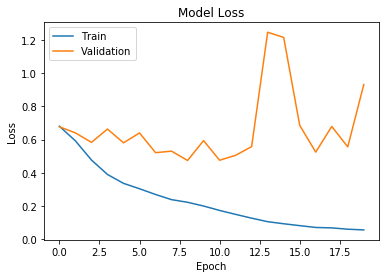

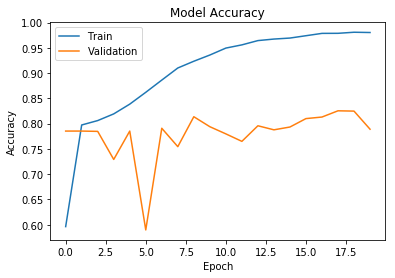

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [19]:
# Predict classes for test data
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1275   19]
 [ 300   28]]


In [20]:
# Classification Report
class_report = classification_report(Y_true, Y_pred_classes)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1294
           1       0.60      0.09      0.15       328

    accuracy                           0.80      1622
   macro avg       0.70      0.54      0.52      1622
weighted avg       0.77      0.80      0.74      1622

